In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.ndimage import gaussian_filter1d

# 设置全局字体
matplotlib.rcParams["font.family"] = "SimSun"
raw_data = pd.read_csv(r"data\qiyeshuju-4S间隔.csv", encoding="gbk")
raw_data.index = pd.to_datetime(raw_data["时间"])
raw_data.drop("时间", axis=1, inplace=True)

columns = raw_data.columns
print(columns)



Index(['右侧换火信号', 'CEMS出口烟尘($mg/m^{3}$)', 'CEMS出口一氧化氮($mg/m^{3}$)',
       'VA.SO2($mg/m^{3}$)', 'VA.NOX($mg/m^{3}$)', 'CEMS出口含氧(%)', 'VA.O2(%)',
       'NOX转换值($mg/m^{3}$)', '氨水泵B频率反馈(Hz)', '1#线氨水流量(L/h)', 'C泵频率反馈(Hz)',
       '反应塔入口温度', '1#线氨水调节阀(L/h)', '反应塔出口温度', 'CCF出口温度', '氨水分段设定反馈($m^{3}/h$)',
       'CCF6温度', 'CCF5温度', 'CCF4温度', 'CCF3温度', 'CCF2温度', '出口CEMS温度', 'CCF1温度',
       'CCF7温度', '喷氨压缩空气压力', 'CCF1差压', 'CCF2差压', 'CCF3差压', 'CCF4差压', 'CCF5差压',
       '反应塔差压', 'CCF6差压', 'B变频器电流(A)', 'A变频器电流(A)', 'B输出频率(Hz)',
       '氨逃逸小时均值($mg/m^{3}$)', 'A输出频率(Hz)', 'CCF7差压', '烟气量($Nm^{3}/h$)',
       'CCF出口压力', 'CEMS出口流量(m/s)', '22出口CEMS温度', '22CEMS出口烟尘($mg/m^{3}$)',
       '出口CEMS湿度(%)', '22烟气量($Nm^{3}/h$)', '右侧换火信号-数值'],
      dtype='object')


DatetimeIndex(['2023-12-11 18:48:28', '2023-12-11 18:48:32',
               '2023-12-11 18:48:36', '2023-12-11 18:48:40',
               '2023-12-11 18:48:44', '2023-12-11 18:48:48',
               '2023-12-11 18:48:52', '2023-12-11 18:48:56',
               '2023-12-11 18:49:00', '2023-12-11 18:49:04',
               ...
               '2024-01-12 17:09:32', '2024-01-12 17:09:36',
               '2024-01-12 17:09:40', '2024-01-12 17:09:44',
               '2024-01-12 17:09:48', '2024-01-12 17:09:52',
               '2024-01-12 17:09:56', '2024-01-12 17:10:00',
               '2024-01-12 17:10:04', '2024-01-12 17:10:08'],
              dtype='datetime64[ns]', name='时间', length=690336, freq=None)


<Axes: xlabel='时间'>

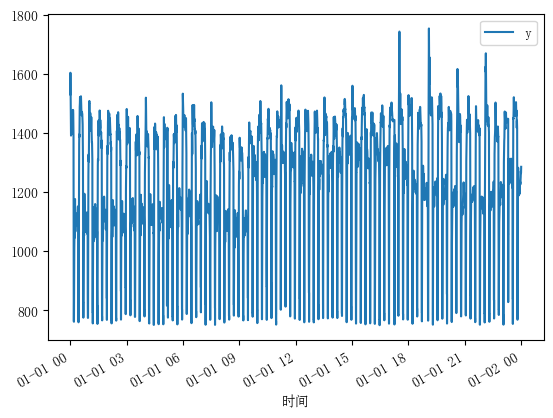

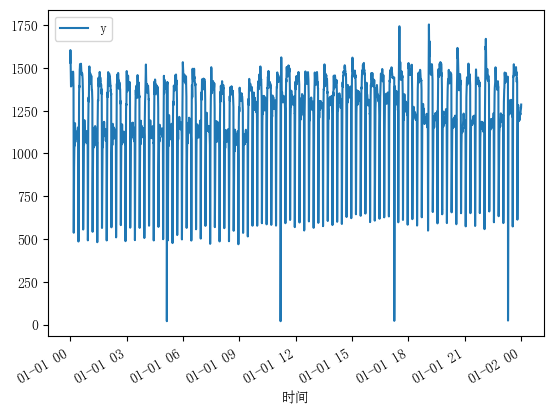

In [27]:
# 选择一天的数据
print(raw_data.index) 
one_data = raw_data["2024-01-1 00:00:00":"2024-01-1 23:59:59"]

test_data = one_data[[r"VA.NOX($mg/m^{3}$)"]]
test_data.columns = ["y"]

origin_test_data = test_data.copy()
## 去除异常值
# 阈值去除
mask = test_data['y'] < 750
test_data.loc[mask, 'y'] = np.nan
test_data['y'].fillna(method='ffill', inplace=True)

# # Z-score去除
# # test_data.columns = ['ds', 'y']   # 假设 'ds' 是日期，'y' 是值
# test_data.loc[:, "ds"] = test_data.index
# # 计算 Z-score
# test_data['z'] = (test_data['y'] - test_data['y'].mean()) / test_data['y'].std()
# test_data = test_data[(test_data['z'] > -3) & (test_data['z'] < 3)]



# 滤波处理
# Apply Gaussian smoothing to the 'y' column of test_data
test_data['y'] = gaussian_filter1d(test_data['y'], sigma=2)

# 现在 y_smooth 包含滤波后的数据








test_data.loc[:, "ds"] = test_data.index
test_data.loc[:, "unique_id"] = [1.0 for i in range(len(test_data))]
test_data.plot(y='y')
origin_test_data.plot(y="y")


In [28]:
n = len(test_data)
train = test_data.iloc[: int(n * 0.9), :]
test = test_data.iloc[int(n * 0.9) :, :]
print(n)

21661


In [29]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, LSTM, GRU
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
# Split data and declare panel dataset
Y_train_df = train
Y_test_df = test
print(len(Y_train_df))
print(len(Y_test_df))

19494
2167


In [30]:

# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [
        #   NBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
          NHITS(input_size=2 * horizon, h=horizon, max_steps=200),
          # LSTM(h=horizon,                    # Forecast horizon
          #      max_steps=20,                # Number of steps to train
          #      scaler_type='standard',       # Type of scaler to normalize data
          #      encoder_hidden_size=16,       # Defines the size of the hidden state of the LSTM
          #      decoder_hidden_size=16,),
          # GRU(h=horizon,                    # Forecast horizon
          #      max_steps=20,                # Number of steps to train
          #      scaler_type='standard',       # Type of scaler to normalize data
          #      encoder_hidden_size=16,       # Defines the size of the hidden state of the LSTM
          #      decoder_hidden_size=16,)                   # Forecast horizon
          ]

nf = NeuralForecast(models=models, freq='4s')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])



Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.13it/s]


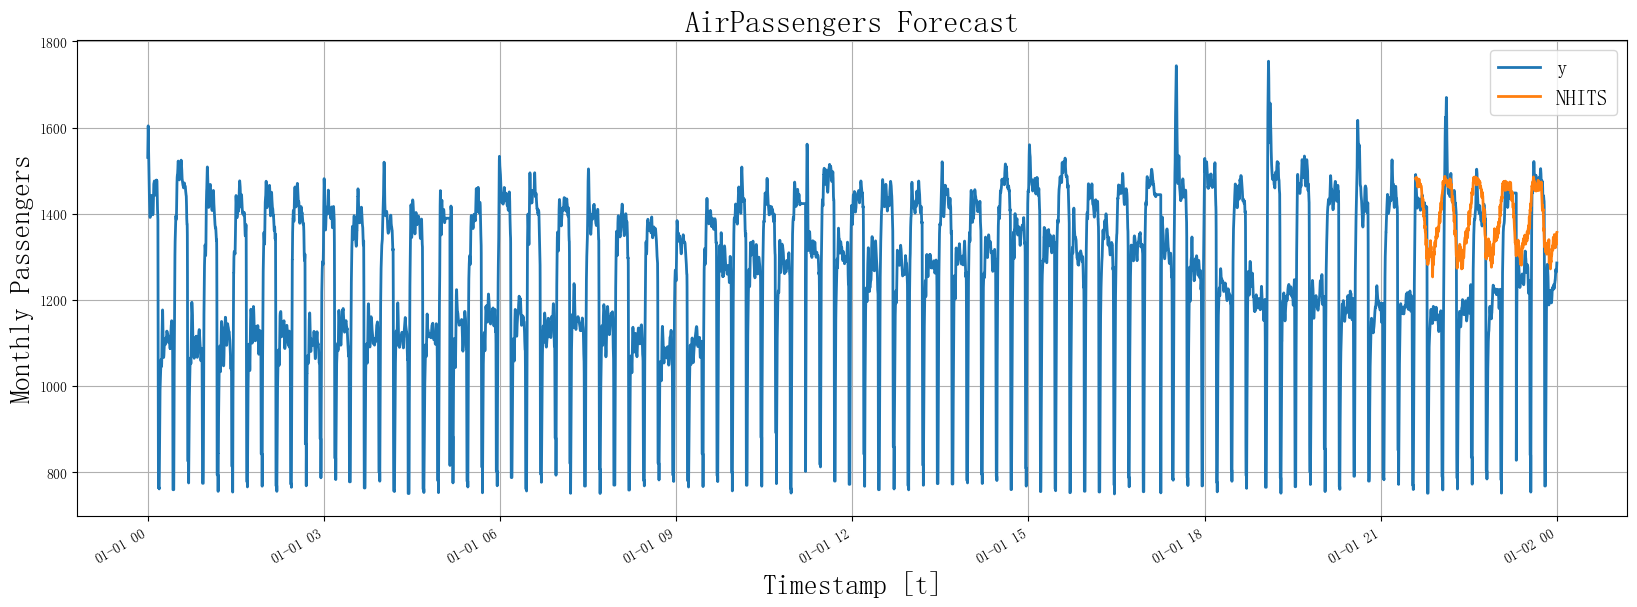

In [33]:
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df.drop('unique_id', axis=1).plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()